import packages
------------------

Some packages are installed automatically if you use Anaconda. As pytorch is used here, you are expected to install that in your machine. 

In [ ]:
# previous version: Copy of classification_preprocessing_cropping_2022_02_09.ipynb

In [ ]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# added to be able to run in Google Colab
import sys
sys.path.append('/content/gdrive/MyDrive/UTRECHT/utils')
sys.path.insert(0,'/content/gdrive/MyDrive/UTRECHT')

import utils

In [ ]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform, morphology, feature, measure
from skimage.morphology import dilation, square, binary_opening
from skimage.color import rgb2gray
import numpy as np
import os.path as path
import scipy.io as sio
import scipy
from scipy import misc
from scipy import ndimage, signal
from scipy.ndimage import gaussian_filter
import pickle
import sys
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import pandas as pd 
import matplotlib.patheffects as path_effects
import csv

from skimage.filters import threshold_otsu

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

# sys.path.append('/home/skong2/project/dpff4ldl')
# from utils.metrics import *
# from losses import *

from utils.flow_functions import *
from utils.dataset import *
from utils.network_arch import *
from utils.trainval_detSegDistTransform import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]
1.12.1+cu113




Evaluation and Visualization
-----

In [ ]:
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal

In [ ]:
# Here define the path, which is used to save the log and trained model in training process

project_name = 'generalizedDet_finetuned_2022_10_18_v3'
# project_name = 'generalizedDet_finetuned_2022_09_14'
# project_name = 'generalizedDet_2022_09_05' 

# cpu or cuda
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda:0'
print(device)

freqShow = 50
weight_reg = 2.0    # balances regression loss with segmentation loss. Value chosen based on past investigation.
weight_background = 0.1   # for regression loss only, downweights background pixels to highlight foreground pollen

#model parameters
batch_size = 4
newSize = [800,800] # set to crop size, to tell model what size tensor to expect
total_epoch_num = 30  # total number of epoch in training
base_lr =0.0005        #0.0005      # base learning rate/
scaleList = [0]      # the number of output layer for U-net
#scale = [0,1,2,3]      # the number of output layer for U-net


exp_dir = '/content/gdrive/MyDrive/exp/final' # experiment directory, used for reading the init model
save_dir = os.path.join(exp_dir, project_name) # where to save the log file and trained models.
if not os.path.exists(save_dir): 
    os.makedirs(save_dir)
log_filename = os.path.join(save_dir, 'train.log')

cuda:0


In [ ]:
eval_dir = '/content/gdrive/MyDrive/eval/final' 
eval_dir = os.path.join(eval_dir, project_name) 
if not os.path.exists(eval_dir): 
    os.makedirs(eval_dir)

In [ ]:
# path_to_image = '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C6/C6_tiles_withAnnot'
path_to_image = '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999'
with open(os.path.join(save_dir,'dbinfo.plk'), 'rb') as handle:
    dbinfo = pickle.load(handle)    
    
dbinfo.keys(), len(dbinfo['train_det_list']), len(dbinfo['test_det_list'])

(dict_keys(['train_det_list', 'test_det_list']), 480, 120)

In [ ]:
################## init model ###################
path_to_save_paramOnly = path.join(exp_dir, project_name, 'bestValModel_encoder.paramOnly')

curmodel = PollenDet_SegDistTransform(34, scaleList=scaleList, pretrained=False)
curmodel.encoder.encoder.conv1 = nn.Conv2d(27, 64, (7, 7), (2, 2), (3, 3), bias=False) #change dimensions of the first layer in the encoder
curmodel.load_state_dict(torch.load(path_to_save_paramOnly)) #, map_location=torch.device('cpu')
curmodel.to(device);    
#print(curmodel.state_dict)
curmodel.eval()
#curmodel.train()
curmodel.training = False
print(curmodel.training)

False


In [ ]:
class PollenDet4Eval(Dataset):
    def __init__(self, path_to_image='/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999',
                #  path_to_annot='/content/gdrive/MyDrive/UTRECHT/Detection/AnnotCombo9_noNPP_circleMask',
                 path_to_mask='/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999',
                 dbinfo=dbinfo,
                 size=[1040,1392], 
                 set_name='test'):
        
        self.path_to_image = path_to_image
        # self.path_to_annot = path_to_annot
        self.path_to_mask = path_to_mask
        self.transform = transform
        self.dbinfo = dbinfo
        if set_name=='val':
            set_name = 'test'
        self.set_name = set_name        
        self.size = size
        self.resizeFactor = size[0]/1000
        
        self.sampleList = self.dbinfo[set_name+'_det_list']

        self.TFNormalize = transforms.Normalize([0.5] * 27, [0.5]*27)
        self.current_set_len = len(self.sampleList)
        
        self.TF2tensor = transforms.ToTensor()
        self.TF2PIL = transforms.ToPILImage()
        self.TFresize = transforms.Resize((self.size[0],self.size[1]))

    def __len__(self):        
        return self.current_set_len
    
    def __getitem__(self, idx):        
        current_example= self.sampleList[idx] 

        current_image_path= os.path.join(self.path_to_image, current_example[0], current_example[0] + '_tiles_withAnnot', current_example[1])
        current_distTransform_path=os.path.join(self.path_to_image, current_example[0], current_example[0] + '_masks2', current_example[1])
        # curPickleName = path.join(self.path_to_annot, current_example)

        imagestack_array = []
        for file in sorted(os.listdir(current_image_path)):
          if file.endswith('.png'):
            slice = Image.open(os.path.join(current_image_path, file))
            imagestack_array.append(np.asarray(slice))
        image = np.block(imagestack_array)
        if image.shape[2] <27:
          pad_val = 27-image.shape[2]
          npad = ((0, 0), (0,0), (0,pad_val))
          image= np.pad(image, pad_width=npad, mode='constant', constant_values=0)

        for file in sorted(os.listdir(current_distTransform_path)):
          if file.endswith('.png'):
            mask = Image.open(os.path.join(current_distTransform_path, file))
            mask=np.expand_dims(mask, axis=2)           

        label = np.copy(mask)         # 11/30/21 added
        label[label > 0] = 1          # 11/30/21 added       

        image_label = np.concatenate((image, label, mask), axis=2) #12/13/21 added


        mask_distanceTransform = np.copy(mask)     #11/18/21 edited
        
        labelOrgSize = np.copy(mask)
        labelOrgSize = torch.from_numpy(labelOrgSize).unsqueeze(0).unsqueeze(0).squeeze(4)

        mask_distanceTransform = mask_distanceTransform.astype(np.float32)/100.0/self.resizeFactor  # factor=size[0]/1000

        image = self.TF2tensor(image)
        label = torch.from_numpy(label).unsqueeze(0) # self.TF2tensor(label)       
        mask_distanceTransform = torch.from_numpy(mask_distanceTransform).unsqueeze(0) # self.TF2tensor(mask_distanceTransform)

        image = image.unsqueeze(0)
        label = label.unsqueeze(0)        
        mask_distanceTransform = mask_distanceTransform.unsqueeze(0)       

        height,width,layer = image_label.shape
        crop0 = image_label[0:800, 0:800,:]
        crop1 = image_label[0:800, width-800:,:]
        crop2 = image_label[height-800:, 0:800,:]
        crop3 = image_label[height-800:, width-800:,:]

        croplist = [crop0, crop1, crop2, crop3]
        imgList=[]
        labelList=[]
        mask_DTList=[]

        for idx2 in range(len(croplist)):
          image_label = croplist[idx2]
          image_label = self.TF2tensor(image_label)
          image_label = image_label.unsqueeze(0)  
          image = torch.narrow(image_label, 1, 0, image_label.shape[1]-2) 
          label=torch.narrow(image_label, 1, image_label.shape[1]-2, 1) 
          mask_distanceTransform=torch.narrow(image_label, 1, image_label.shape[1]-1, 1)

          image_label = image_label.squeeze(0)
          image = image.type(torch.float)
          image = self.TFNormalize(image)

          imgList.append(image)
          labelList.append(label)
          mask_DTList.append(mask_distanceTransform)

        image = torch.concat(imgList)
        label = torch.concat(labelList)
        mask_distanceTransform = torch.concat(mask_DTList)

        image = image.squeeze(0)
        label = label.squeeze(0)
        mask_distanceTransform = mask_distanceTransform.squeeze(0)
        labelOrgSize = labelOrgSize.squeeze(0)

        return image, label, mask_distanceTransform, labelOrgSize, current_example
        # return image, label, mask_distanceTransform, mask_overlap, mask_voteX, mask_voteY, mask_peaks, mask_radius, labelOrgSize, mask_peaksOrgSize, mask_distanceTransformOrgSize, mask_radiusOrgSize

In [ ]:
set_name = 'test'
det_datasets = PollenDet4Eval(path_to_image=path_to_image,
                              # path_to_annot=path_to_annotCombo,
                              dbinfo=dbinfo, size=newSize, set_name=set_name)

dataloaders = DataLoader(det_datasets,
                         batch_size=1,
                         shuffle=True, 
                         num_workers=8) # num_work can be set to batch_size



In [ ]:
sampler = iter(dataloaders)

In [ ]:
print(len(dataloaders))

480


In [ ]:
curImg, curLabel, curMask, curMask_orgSize, current_example = next(sampler)
# curImg, curBinaryMask, curDTMask, curImgPath = next(sampler)
print(current_example)

curImg = curImg.to(device)
# curImg, curLabel, curMask, curMask_orgSize = curImg.to(device), curLabel.to(device), curMask.to(device), curMask_orgSize.to(device)
curImg_squeeze=torch.squeeze(curImg,0)

outputs = curmodel(curImg_squeeze)
predSeg = outputs[('segMask', 0)]
predDistTransform = outputs[('output', 0)]

[('C3',), ('48352x_43120y',)]


In [ ]:
print(current_example[1][0])

48352x_43120y


In [ ]:
print(predSeg.shape)

torch.Size([4, 1, 800, 800])


In [ ]:
# m = nn.Softmax(dim=0)
# softmax = m(predDistTransform) # use image
softmax = predSeg

# print(softmax)

In [ ]:
print(predSeg.max(),predSeg.min())


tensor(0.6470, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.0002, device='cuda:0', grad_fn=<MinBackward1>)


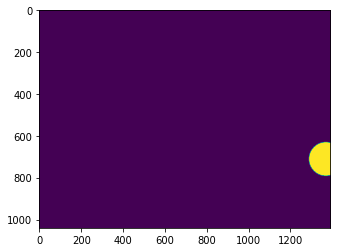

In [ ]:
curmask_OrgSize = curMask_orgSize.squeeze().cpu().detach().numpy()
curmask_OrgSize_binary = curmask_OrgSize >0.5
plt.imshow(curmask_OrgSize_binary)

In [ ]:
# create a list of (800x800) prediction distance transforms crops and softmax crops

predDistTransform_crops=[]
softmax_crops = []

for idx in range(0,4):
  tmpImg =  predDistTransform[idx,:,:,:].squeeze().cpu().detach().numpy() 
  predDistTransform_crops.append(tmpImg)

for idx in range(0,4):
  tmpImg =  softmax[idx,:,:,:].squeeze().cpu().detach().numpy() 
  softmax_crops.append(tmpImg)


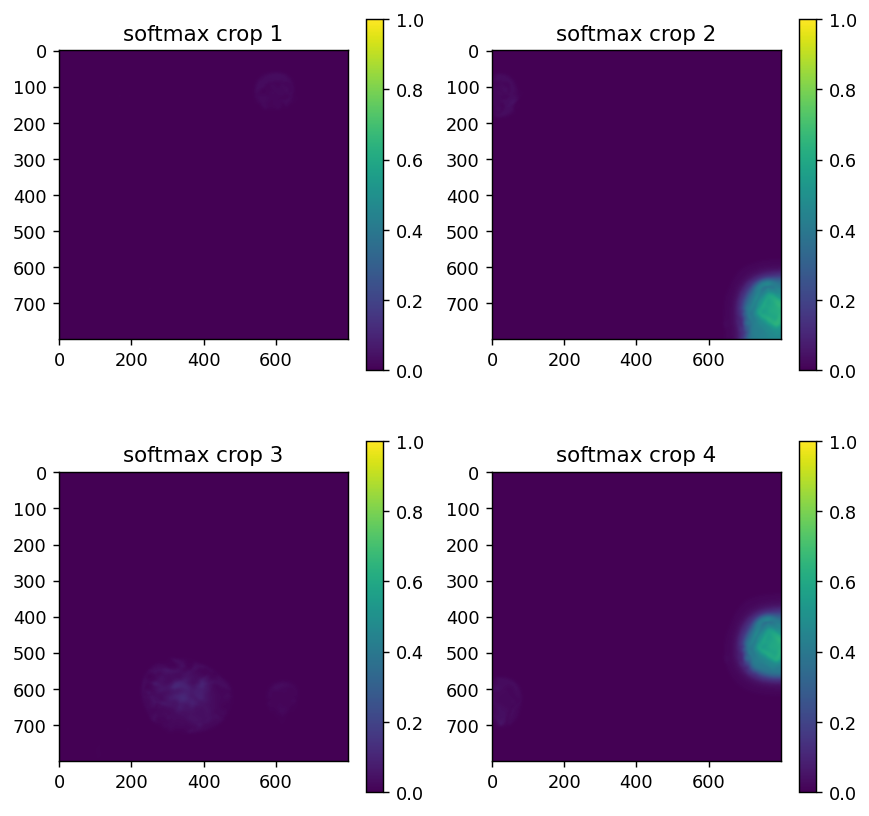

In [ ]:
numSample2Show = 1
figWinNumHeight, figWinNumWidth = 2, 2
plt.figure(figsize=(8,8), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg =  softmax_crops[0]
plt.imshow(tmpImg, vmin=0, vmax=1)
plt.title('softmax crop 1')
plt.colorbar()

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg =  softmax_crops[1]
plt.imshow(tmpImg, vmin=0, vmax=1)
plt.title('softmax crop 2')
plt.colorbar()

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg =  softmax_crops[2]
plt.imshow(tmpImg, vmin=0, vmax=1)
plt.title('softmax crop 3')
plt.colorbar()

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg =  softmax_crops[3]
plt.imshow(tmpImg, vmin=0, vmax=1)
plt.title('softmax crop 4')
plt.colorbar()

0.8671801
0.8290128
(1040, 1392)


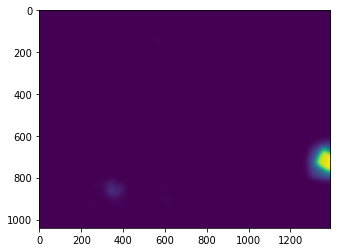

In [ ]:
# create full-sized pred distance transform 

mask_OrgSize = curMask_orgSize.squeeze().cpu().detach().numpy()

height,width = mask_OrgSize.shape
predDistTransform=np.zeros_like(mask_OrgSize)  
predDistTransform=predDistTransform.astype(np.float32)

tmp_predDistTransform_1=np.zeros_like(mask_OrgSize).astype(np.float32)
tmp_predDistTransform_2=np.zeros_like(mask_OrgSize).astype(np.float32)
tmp_predDistTransform_3=np.zeros_like(mask_OrgSize).astype(np.float32)
tmp_predDistTransform_4=np.zeros_like(mask_OrgSize).astype(np.float32)


tmp_predDistTransform_1[0:800, 0:800]=predDistTransform_crops[0]
tmp_predDistTransform_2[0:800, width-800:]=predDistTransform_crops[1]
tmp_predDistTransform_3[height-800:, 0:800]=predDistTransform_crops[2]
tmp_predDistTransform_4[height-800:, width-800:]=predDistTransform_crops[3]

predDistTransform = np.maximum.reduce([tmp_predDistTransform_1,tmp_predDistTransform_2,tmp_predDistTransform_3,tmp_predDistTransform_4]) 

print(np.amax(predDistTransform))
# if np.amax(predDistTransform)>1:
#   predDistTransform *= 1/predDistTransform.max() 

predDistTransform = gaussian_filter(predDistTransform, sigma=10) # gaussian blur to get rid of shadow
print(np.amax(predDistTransform))

# im = Image.fromarray(predDistTransform.astype(np.uint8))
plt.imshow(predDistTransform)
print(predDistTransform.shape)
# print(predDistTransform.dtype)
# im.save(os.path.join(eval_save_to_folder, 'predDistTransform_full.png'))

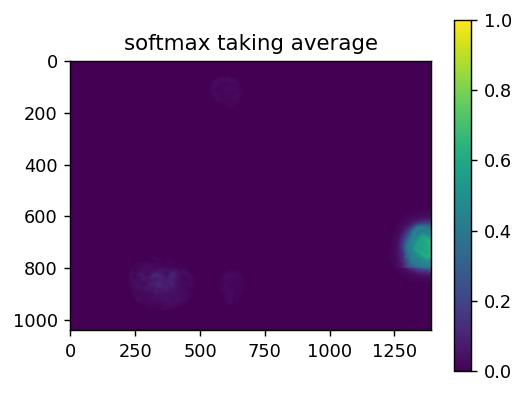

In [ ]:
# create full-sized softmax

# mask_OrgSize = curMask_orgSize.squeeze().cpu().detach().numpy()

height,width = mask_OrgSize.shape
softmax=np.zeros_like(mask_OrgSize)  
softmax=softmax.astype(np.float32)

tmp_softmax_1=np.zeros_like(mask_OrgSize).astype(np.float32)
tmp_softmax_2=np.zeros_like(mask_OrgSize).astype(np.float32)
tmp_softmax_3=np.zeros_like(mask_OrgSize).astype(np.float32)
tmp_softmax_4=np.zeros_like(mask_OrgSize).astype(np.float32)

tmp_softmax_1[0:800, 0:800]=softmax_crops[0]
tmp_softmax_2[0:800, width-800:]=softmax_crops[1]
tmp_softmax_3[height-800:, 0:800]=softmax_crops[2]
tmp_softmax_4[height-800:, width-800:]=softmax_crops[3]

# softmax = np.maximum.reduce([tmp_softmax_1,tmp_softmax_2,tmp_softmax_3,tmp_softmax_4]) 
# softmax = np.mean( np.array([tmp_softmax_1,tmp_softmax_2,tmp_softmax_3,tmp_softmax_4]), axis=0 )

numSample2Show = 1
figWinNumHeight, figWinNumWidth = 2, 2
plt.figure(figsize=(10,8), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    

tmp_softmax_1[tmp_softmax_1 == 0] = np.nan
tmp_softmax_2[tmp_softmax_2 == 0] = np.nan
tmp_softmax_3[tmp_softmax_3 == 0] = np.nan
tmp_softmax_4[tmp_softmax_4 == 0] = np.nan

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg =  np.nanmean(np.array([tmp_softmax_1,tmp_softmax_2,tmp_softmax_3,tmp_softmax_4]), axis=0)
softmax=tmpImg
plt.imshow(tmpImg, vmin = 0, vmax = 1)
plt.title('softmax taking average')
plt.colorbar()


# # plt.imshow(softmax)
# print(softmax.shape)

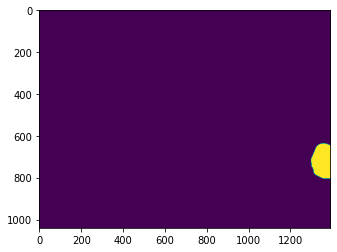

In [ ]:
predBinaryMask = softmax>0.4
predBinaryMask=binary_opening(predBinaryMask,square(5))
predBinaryMask = dilation(predBinaryMask,square(10))
plt.imshow(predBinaryMask)

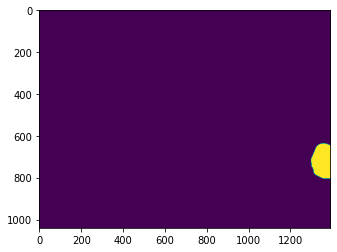

In [ ]:
predSegMask = measure.label(predBinaryMask, background=0)
plt.imshow(predSegMask, cmap='viridis')

In [ ]:
def create_circular_mask(mask, center, radius, value=1):
    h, w = mask.shape[:2]
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((Y - center[0])**2 + (X-center[1])**2)

    tmpMask = dist_from_center <= radius
    mask[tmpMask] = value
    
    return mask

In [ ]:
def create_reverse_mask(mask, center, radius, value=1):
    h, w = mask.shape[:2]
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((Y - center[0])**2 + (X-center[1])**2)

    tmpMask = dist_from_center > radius
    mask[tmpMask] = value
    
    return mask

In [ ]:
def IOU(box1, box2):
    """
We assume that the box follows the format:
box1 = [x1,y1,x2,y2], and box2 = [x3,y3,x4,y4],
where (x1,y1) and (x3,y3) represent the top left coordinate,
and (x2,y2) and (x4,y4) represent the bottom right coordinate
    """
    x1, y1, x2, y2 = box1	
    x3, y3, x4, y4 = box2
    
    assert x1 < x2
    assert y1 < y2
    assert x3 < x4
    assert y3 < y4

    # determine the coordinates of the intersection rectangle
    x_left = max(x1, x3)
    y_top = max(y1, y3)
    x_right = min(x2, x4)
    y_bottom = min(y2, y4)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left + 1) * (y_bottom - y_top + 1)
    
    # compute the area of both AABBs
    bb1_area = (x2 - x1) * (y2 - y1)
    bb2_area = (x4 - x3) * (y4 - y3)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.1
    return iou

In [ ]:
def nms(boxes, conf_threshold=0.1, iou_threshold=0.5):
    bbox_list_thresholded = []
    bbox_list_new = []
    bbox_list_new_txt = []
    # detMask_info = detMask_info

    # Stage 1: sort boxes, filter out boxes with low confidence
    boxes_sorted = sorted(boxes, reverse=True, key = lambda x : x[1])
    for box in boxes_sorted:
        if box[1] > conf_threshold:
            bbox_list_thresholded.append(box)
        else:
            pass
    # Stage 2: loop through the boxes, remove boxes with high IoU
    while len(bbox_list_thresholded) > 0:
        current_box = bbox_list_thresholded.pop(0)
        bbox_list_new.append(current_box)
        current_box_txt = (current_box[0], str(current_box[1]) , str(current_box[2]), str(current_box[3]), str(current_box[4]), str(current_box[5]) )
        current_box_txt = ' '.join(current_box_txt)
        bbox_list_new_txt.append(current_box_txt)

        for box in bbox_list_thresholded:
            if current_box[0] == box[0]:
                iou = IOU(current_box[2:], box[2:])
                # print(iou)
                if iou > iou_threshold:
                    bbox_list_thresholded.remove(box)
                    # detMask_info.remove()

    return  bbox_list_new, bbox_list_new_txt

In [ ]:
pred_distanceTransform = np.copy(predDistTransform)

voting4center = np.copy(pred_distanceTransform)
voting4center[voting4center<0.1] = 0 #changed from voting4center[voting4center<0.1]

In [ ]:
coord_peaks = feature.peak_local_max(voting4center, min_distance=50, exclude_border=False) #originally min_distance =5, changed to 25
print(coord_peaks)

[[ 741 1391]
 [ 861  345]]


In [ ]:
import json
from skimage.draw import circle_perimeter, disk

# do_not_include =['ind', 'spr', 'fun', 'fun?', 'fungal spore' 'what is this?']

slice_path=[]
full_label_names = []
center_radius_list = []

current_image_path= os.path.join(path_to_image, current_example[0][0], current_example[0][0] + '_tiles_withAnnot', current_example[1][0])
for file in sorted(os.listdir(str(current_image_path))):
    if file.endswith('.png'):
      slice = os.path.join(str(current_image_path), file)
      slice_path.append(slice)
    if file.endswith('full_annot.plk'):
      print('a')
      with open(os.path.join(current_image_path,'full_annot.plk'), 'rb') as handle:
          tmpData = pickle.load(handle)
          # tmpData = json.load(f)            
          for shape in tmpData:
              # full_annot.append(shape)
              label_name = shape["label"]
              # if label_name in do_not_include:
              #     continue
              points = shape['points']

              # # export crop masks
              xy = [tuple(point) for point in points]
              (cx, cy), (px, py) = xy
              d = math.sqrt((cx - px) ** 2 + (cy - py) ** 2)
              center_radius_list.append((cx,cy,d,label_name))

img_without_label = mpimg.imread(slice_path[5]).copy()
img_with_label = mpimg.imread(slice_path[5]).copy()

a


In [ ]:
center_radius_list

[(1367.1159420289855, 710.855072463768, 79.92067060267965, 'aln')]

In [ ]:
class_labels = os.path.join(eval_dir, 'finetunedModel', 'crops', 'Labels')
if not os.path.exists(class_labels): 
    os.makedirs(class_labels)
print(class_labels)

class_imgs = os.path.join(eval_dir, 'finetunedModel','crops','Images')
if not os.path.exists(class_imgs): 
    os.makedirs(class_imgs)

class_masks = os.path.join(eval_dir, 'finetunedModel','crops', 'Masks')
if not os.path.exists(class_masks): 
    os.makedirs(class_masks)

false_det_labels = os.path.join(eval_dir, 'finetunedModel','crops','False_Det','Labels')
if not os.path.exists(false_det_labels): 
    os.makedirs(false_det_labels)

false_det_imgs = os.path.join(eval_dir, 'finetunedModel','crops','False_Det','Images')
if not os.path.exists(false_det_imgs): 
    os.makedirs(false_det_imgs)

false_det_masks = os.path.join(eval_dir, 'finetunedModel','crops','False_Det', 'Masks')
if not os.path.exists(false_det_masks): 
    os.makedirs(false_det_masks)

/content/gdrive/MyDrive/eval/final/generalizedDet_finetuned_2022_10_18_v3/finetunedModel/crops/Labels


0.5509608874537785
0.0


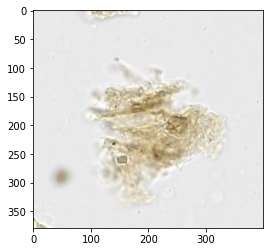

In [ ]:
# from torch._C import R
# create detection mask using peaks and predicted radius
# coord_peaks = feature.peak_local_max(voting4center, min_distance=25, exclude_border=False) #originally min_distance =5, changed to 25

# centerMask = voting4center*0
detMask = voting4center*0
predRadiusList = []
detection_info2 = []

size = (400,400)

for i in range(coord_peaks.shape[0]):
    #############################create full image detection mask##########################################################
    y, x = coord_peaks[i]
    #centerMask[y, x] = 1
    # centerMask[y-10:y+10, x-10:x+10] = 1

    left = int(x-(size[0]/2))
    left=max(left,0)
    top = int(y-(size[0]/2))
    top=max(top,0)
    right = int(x+(size[0]/2))
    right=max(right,0)
    bottom = int(y+(size[0]/2))
    bottom=max(bottom,0)

    tmpCrop = softmax[top:bottom, left:right]
    thresh = threshold_otsu(tmpCrop) 
    tmpCrop = tmpCrop> thresh # binarize
    tmpCrop= measure.label(tmpCrop, background=0)
    props = measure.regionprops(tmpCrop) #get the properties of the connected components

    diameter = [prop.major_axis_length for prop in props]   #diameter for connected components
    if len(diameter) != 0 and max(diameter) != 0:
      radius = int(max(diameter)/2)
      predRadiusList += [radius]
      a = len(predRadiusList)-1

      tmpMask = voting4center*0
      tmpMask = create_circular_mask(tmpMask, [y, x], predRadiusList[a], value=1)

      class_name="det"
      leftBb = x-radius
      leftBb = max(leftBb,0)
      topBb = y-radius
      topBb= max(topBb,0)
      rightBb = x+radius
      rightBb = max(rightBb, 0)
      bottomBb = y+radius
      bottomBb = max(bottomBb,0)

      masked_softmax = np.ma.masked_where(tmpMask==0, softmax) 
      confidence = np.nanmean(masked_softmax)
      if confidence > 0.99:
        confidence = 0
      bbox_info2 = [class_name, confidence, leftBb, topBb, rightBb, bottomBb]

      detMask = create_circular_mask(detMask, [y, x], predRadiusList[a], value=a+1)
      detection_info2.append(bbox_info2)

    if len(center_radius_list) == 0:
      continue
    # Apply non-max suppression
    NMS_bb = nms(detection_info2,conf_threshold=0, iou_threshold=0.3)
    NMS_bb = NMS_bb[0]


    #############################crop detection mask##########################################################
    crop_mask = tmpMask[top:bottom, left:right]

    #############################crop image and select the clearest slice##########################################################
    edges = []

    for idx in range(len(slice_path)):
      tmpImg = mpimg.imread(slice_path[idx])
      tmpImg = tmpImg[top:bottom, left:right]
 
      tmpImg_grayscale = rgb2gray(tmpImg)
      edges2 = feature.canny(tmpImg_grayscale, sigma=1)
      edges.append(np.count_nonzero(edges2))

    max_value=max(edges) #find the max number of non-zero pixels in img array to find clearest slice
    max_idx = edges.index(max_value) #find the index of that slice

    clearest_slice =  PIL.Image.open(slice_path[max_idx])
    clearest_slice = np.array(clearest_slice)[top:bottom, left:right]

    ############################ attach class label ######################################################## 
    pred_bb = [leftBb, topBb, rightBb, bottomBb]
    gt_bb_list = []

    for j in range(len(center_radius_list)):
        cur_class_label_full = center_radius_list[j]
        code = str(cur_class_label_full[3])
        cy = int(center_radius_list[j][0])
        cx = int(center_radius_list[j][1])
        r = int(center_radius_list[j][2])

        gt_leftBb = cy-r
        gt_topBb = cx-r
        gt_rightBb = cy+r
        gt_bottomBb = cx+r
        gt_bb = [gt_leftBb,gt_topBb,gt_rightBb,gt_bottomBb]
        gt_bb_list.append(gt_bb)

        iou = IOU(gt_bb,pred_bb)
        print(iou)
        if iou>0.3:
            # print(code)
            # print(iou)

            # save clearest slice of cropped image
            img_path = os.path.join(class_imgs,code)
            if not os.path.exists(img_path): 
                os.makedirs(img_path)

            k = 1
            img_filename = "{}/{}_{}{}".format(img_path, current_example[1][0], k, '.png')
            while os.path.exists(img_filename):
                img_filename = "{}/{}_{}{}".format(img_path, current_example[1][0], k, '.png')
                k += 1

            if isinstance(clearest_slice, np.ndarray):
                clearest_slice = PIL.Image.fromarray(clearest_slice)
            clearest_slice.save(img_filename)

            # save cropped mask
            mask_path = os.path.join(class_masks,code)
            if not os.path.exists(mask_path): 
                os.makedirs(mask_path)

            k=1
            mask_filename = "{}/{}_{}{}".format(mask_path, current_example[1][0], k, '.png')
            while os.path.exists(mask_filename):
                mask_filename = "{}/{}_{}{}".format(mask_path, current_example[1][0], k, '.png')
                k += 1

            if isinstance(crop_mask, np.ndarray):
                crop_mask = PIL.Image.fromarray((crop_mask * 255).astype(np.uint8))
            crop_mask.save(mask_filename)
            # continue

plt.imshow(clearest_slice)

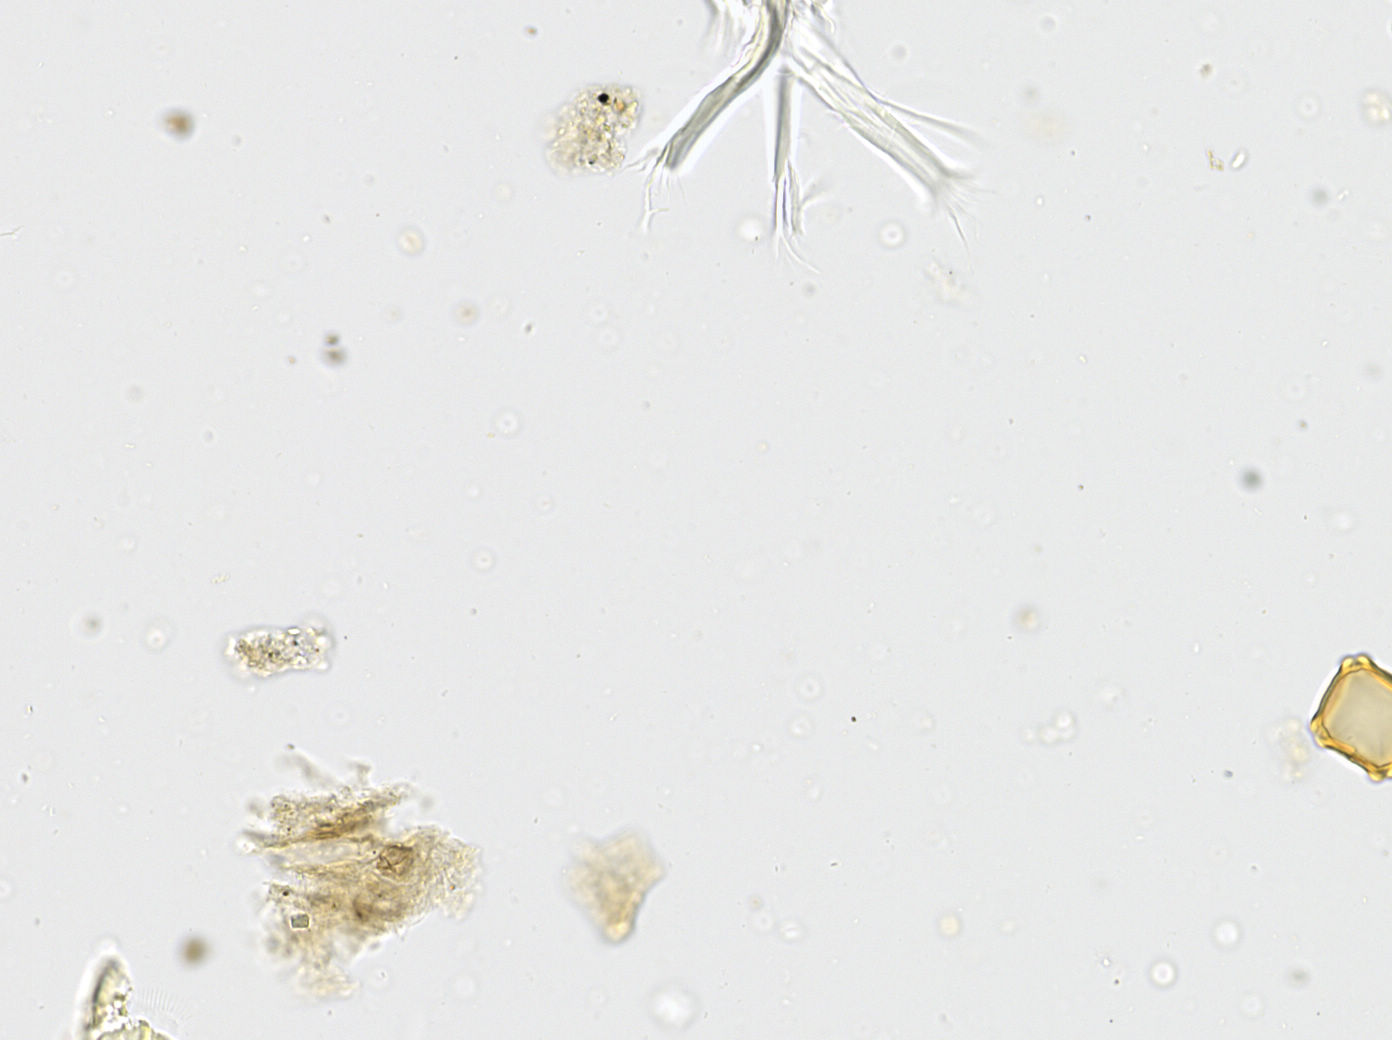

In [ ]:
PIL.Image.open(slice_path[max_idx])

In [ ]:
# export image, detection mask, and csv/.pkl of info
# csv info: original image name, crop coordinates (top, left, bottom, right), center, radius, class id

In [ ]:
print(center_radius_list)

[(1367.1159420289855, 710.855072463768, 79.92067060267965, 'aln')]


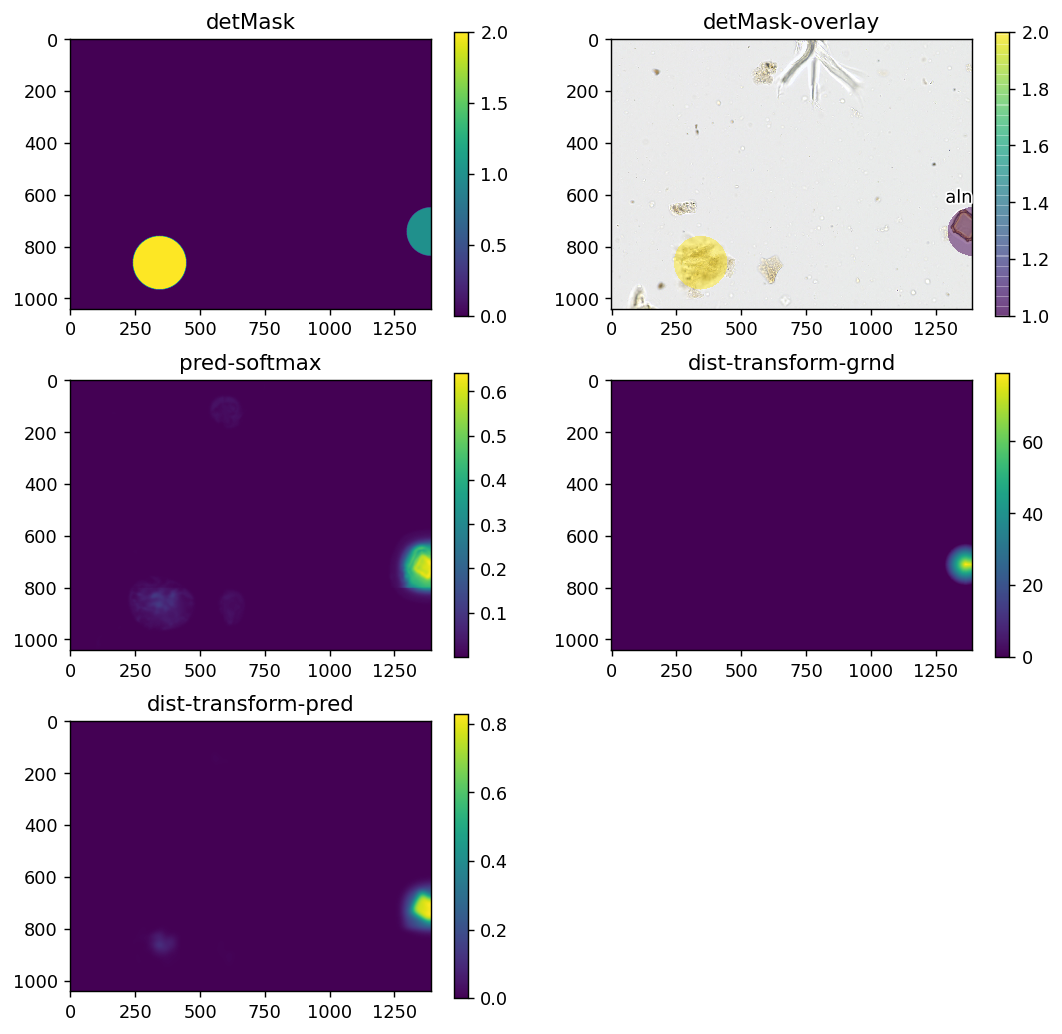

In [ ]:
numSample2Show = 1
figWinNumHeight, figWinNumWidth = 3, 2
plt.figure(figsize=(10,10), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    

# plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
# subwinCount += 1
# plt.imshow(centerMask)
# plt.title('centerMask')
# plt.colorbar()
# # plt.imsave(os.path.join(eval_save_to_folder, 'centerMask.png'), centerMask, format='png')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(detMask)
plt.title('detMask')
plt.colorbar()
# plt.imsave(os.path.join(eval_save_to_folder, 'detMask.png'), tmpImg, format='png')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
masked = np.ma.masked_where(detMask == 0, detMask)
for idx in range(len(center_radius_list)):
    y = int(center_radius_list[idx][0])
    x = int(center_radius_list[idx][1])
    r = int(center_radius_list[idx][2])
    rr, cc = circle_perimeter(x,y,r)
    # img_with_label[rr, cc] = 0
    plt.text(y-r,x-r, center_radius_list[idx][3],
          fontsize=10,
          color='black', path_effects=[path_effects.withStroke(linewidth=2, foreground="w")])
plt.imshow(img_with_label, interpolation='none')
plt.imshow(masked, 'viridis', interpolation='none', alpha=0.5)    #'jet' also works as color
plt.title('detMask-overlay')
plt.colorbar()

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(softmax)
plt.title('pred-softmax')
plt.colorbar()

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = mask_OrgSize
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('dist-transform-grnd')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(pred_distanceTransform)
plt.title('dist-transform-pred')
plt.colorbar()

In [ ]:
# compile all annotations into a CSV
iterCount, sampleCount = 0, 0
phase = 'train'
for sample in dataloaders: 
            
    curImg, curLabel, curMask, curMask_orgSize, current_example = sample
    
    curImg, curLabel, curMask, curMask_orgSize = curImg.to(device), curLabel.to(device), curMask.to(device), curMask_orgSize.to(device)

    curImg_squeeze=torch.squeeze(curImg,0)

    iterCount += 1
    sampleCount += curLabel.size(0)   
    
    outputs = curmodel(curImg_squeeze)
    predSeg = outputs[('segMask', 0)]
    predDistTransform = outputs[('output', 0)]

    softmax = predSeg
    
    if iterCount%50==0:
        print('{}/{}'.format(iterCount,len(det_datasets)))

    ######################################################
    #       ground-truth: labelOrgSize, mask_peaksOrgSize
    ######################################################
    current_image_path= os.path.join(path_to_image, current_example[0])
    path_to_imdb = os.path.join(str(current_image_path), 'annot.csv')
    imdb = pd.read_csv(path_to_imdb, dtype=object)

    class_label_full = pd.DataFrame(imdb, columns = ['X Coord of Bb','Y Coord of Bb','Bb Width','Bb Height', 'Code'])
    class_label_full= class_label_full.to_numpy()

    curmask_OrgSize = curMask_orgSize.squeeze().cpu().detach().numpy()
    GTSegMask = curmask_OrgSize >0.5
    GTSegMask = measure.label(GTSegMask, background=0)

    props = measure.regionprops(np.squeeze(GTSegMask)) #get the properties of the connected components
    bbox = [prop.bbox for prop in props]   #bounding box coordinates for connected components
    # gt_filename = os.path.join(gt_dir, current_example[0] + '.txt')
    # i=2
    for i in range(len(props)): 
      left = bbox[i][1]
      top = bbox[i][0]
      right = bbox[i][3]
      bottom = bbox[i][2]
      new_gt_bb = [left, top, right, bottom]
      for j in range(len(class_label_full)):
          cur_class_label_full = class_label_full[j]
          code = cur_class_label_full[4]
          gt_leftBb = int(cur_class_label_full[0])
          gt_topBb= int(cur_class_label_full[1])
          gt_rightBb = int(cur_class_label_full[0]) + int(cur_class_label_full[2])
          gt_bottomBb = int(cur_class_label_full[1]) + int(cur_class_label_full[3])

          old_gt_bb = [gt_leftBb, gt_topBb, gt_rightBb, gt_bottomBb]
          iou = IOU(new_gt_bb,old_gt_bb)

          if iou>0.25 and iou <1:
          # updating the bb coordinates
              imdb.iloc[j]['X Coord of Bb']= left
              imdb.iloc[j]['Y Coord of Bb']= top
              imdb.iloc[j]['Bb Width'] = right - left
              imdb.iloc[j]['Bb Height'] = bottom - top

              # print(iou)
              # print(code)
              # print(old_gt_bb,new_gt_bb)
              # print(imdb.iloc[j]['X Coord of Bb'])
              # print(imdb.iloc[j]['Y Coord of Bb'])
              # print(imdb.iloc[j]['Bb Width'])
              # print(imdb.iloc[j]['Bb Height'])

          # writing into the file
          new_path_to_imdb = os.path.join(str(current_image_path), 'annot2.csv')
          imdb.to_csv(new_path_to_imdb, index=False, index_label=None)


50/2388
100/2388
150/2388
200/2388
250/2388
300/2388
350/2388
400/2388
450/2388
500/2388
550/2388
600/2388
650/2388
700/2388
750/2388
800/2388
850/2388
900/2388
950/2388
1000/2388
1050/2388
1100/2388
1150/2388
1200/2388
1250/2388
1300/2388
1350/2388
1400/2388
1450/2388
1500/2388
1550/2388
1600/2388
1650/2388
1700/2388
1750/2388
1800/2388
1850/2388
1900/2388
1950/2388
2000/2388
2050/2388
2100/2388
2150/2388
2200/2388
2250/2388
2300/2388
2350/2388


# Export cropped images, masks, labels

In [ ]:
# set directory names
class_labels = os.path.join(eval_dir, 'finetunedModel', 'crops', set_name, 'Labels')
if not os.path.exists(class_labels): 
    os.makedirs(class_labels)

class_imgs = os.path.join(eval_dir, 'finetunedModel', 'crops', set_name,'Images')
if not os.path.exists(class_imgs): 
    os.makedirs(class_imgs)

class_masks = os.path.join(eval_dir, 'finetunedModel', 'crops', set_name,'Masks')
if not os.path.exists(class_masks): 
    os.makedirs(class_masks)

false_det_labels = os.path.join(eval_dir, 'finetunedModel', 'crops', set_name, 'False_Det','Labels')
if not os.path.exists(false_det_labels): 
    os.makedirs(false_det_labels)

false_det_imgs = os.path.join(eval_dir, 'finetunedModel', 'crops', set_name, 'False_Det','Images')
if not os.path.exists(false_det_imgs): 
    os.makedirs(false_det_imgs)

false_det_masks = os.path.join(eval_dir, 'finetunedModel', 'crops', set_name, 'False_Det', 'Masks')
if not os.path.exists(false_det_masks): 
    os.makedirs(false_det_masks)

In [ ]:
iterCount, sampleCount = 0, 0
phase = 'test'
for sample in dataloaders: 
            
    curImg, curLabel, curMask, curMask_orgSize, current_example = sample
    
    curImg, curLabel, curMask, curMask_orgSize = curImg.to(device), curLabel.to(device), curMask.to(device), curMask_orgSize.to(device)

    curImg_squeeze=torch.squeeze(curImg,0)

    iterCount += 1
    sampleCount += curLabel.size(0)   
    
    outputs = curmodel(curImg_squeeze)
    predSeg = outputs[('segMask', 0)]
    predDistTransform = outputs[('output', 0)]

    softmax = predSeg
    
    slab_name = current_example[0][0]
    # sample_name = 
    tile_name = current_example[1][0]

    if iterCount%25==0:
        print('{}/{}'.format(iterCount,len(det_datasets)))

    ##############################################
    ##          prediction: 
    ##############################################
    # create a list of (800x800) prediction distance transforms crops and softmax crops

    predDistTransform_crops=[]
    softmax_crops = []

    for idx in range(0,4):
      tmpImg =  predDistTransform[idx,:,:,:].squeeze().cpu().detach().numpy() 
      predDistTransform_crops.append(tmpImg)

    for idx in range(0,4):
      tmpImg =  softmax[idx,:,:,:].squeeze().cpu().detach().numpy() 
      softmax_crops.append(tmpImg)

    # create full-sized pred distance transform 
    mask_OrgSize = curMask_orgSize.squeeze().cpu().detach().numpy()

    height,width = mask_OrgSize.shape
    predDistTransform=np.zeros_like(mask_OrgSize)  
    predDistTransform=predDistTransform.astype(np.float32)

    tmp_predDistTransform_1=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_predDistTransform_2=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_predDistTransform_3=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_predDistTransform_4=np.zeros_like(mask_OrgSize).astype(np.float32)


    tmp_predDistTransform_1[0:800, 0:800]=predDistTransform_crops[0]
    tmp_predDistTransform_2[0:800, width-800:]=predDistTransform_crops[1]
    tmp_predDistTransform_3[height-800:, 0:800]=predDistTransform_crops[2]
    tmp_predDistTransform_4[height-800:, width-800:]=predDistTransform_crops[3]

    predDistTransform = np.maximum.reduce([tmp_predDistTransform_1,tmp_predDistTransform_2,tmp_predDistTransform_3,tmp_predDistTransform_4]) 
    predDistTransform = gaussian_filter(predDistTransform, sigma=10) # gaussian blur to get rid of shadow
    pred_distanceTransform = np.copy(predDistTransform)

    # create full-sized softmax
    height,width = mask_OrgSize.shape
    softmax=np.zeros_like(mask_OrgSize)  
    softmax=softmax.astype(np.float32)

    tmp_softmax_1=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_softmax_2=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_softmax_3=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_softmax_4=np.zeros_like(mask_OrgSize).astype(np.float32)

    tmp_softmax_1[0:800, 0:800]=softmax_crops[0]
    tmp_softmax_2[0:800, width-800:]=softmax_crops[1]
    tmp_softmax_3[height-800:, 0:800]=softmax_crops[2]
    tmp_softmax_4[height-800:, width-800:]=softmax_crops[3]

    # softmax = np.maximum.reduce([tmp_softmax_1,tmp_softmax_2,tmp_softmax_3,tmp_softmax_4]) 
    softmax =  np.nanmean(np.array([tmp_softmax_1,tmp_softmax_2,tmp_softmax_3,tmp_softmax_4]), axis=0)

    # find peaks, zero-out background noise
    voting4center = np.copy(pred_distanceTransform)
    voting4center[voting4center<0.1] = 0
    coord_peaks = feature.peak_local_max(voting4center, min_distance=50, exclude_border=False) #originally min_distance =5, changed to 25

    # list filenames for images in the stack
    slice_path=[]
    center_radius_list = []
    current_image_path= os.path.join(path_to_image, slab_name, slab_name + '_tiles_withAnnot', tile_name)
    for file in sorted(os.listdir(str(current_image_path))):
        if file.endswith('.png'):
          slice = os.path.join(str(current_image_path), file)
          slice_path.append(slice)
        if file.endswith('full_annot.plk'):
          with open(os.path.join(current_image_path,'full_annot.plk'), 'rb') as handle:
              tmpData = pickle.load(handle)
              # tmpData = json.load(f)            
              for shape in tmpData:
                  # full_annot.append(shape)
                  label_name = shape["label"]
                  # if label_name in do_not_include:
                  #     continue
                  points = shape['points']

                  # # export crop masks
                  xy = [tuple(point) for point in points]
                  (cx, cy), (px, py) = xy
                  d = math.sqrt((cx - px) ** 2 + (cy - py) ** 2)
                  center_radius_list.append((cx,cy,d,label_name))

    # create detection mask using peaks and predicted radius
    centerMask = voting4center*0
    detMask = voting4center*0
    predRadiusList = []
    detection_info2 = []

    size = (400,400)

    for i in range(coord_peaks.shape[0]):
        #############################create full image detection mask##########################################################
        y, x = coord_peaks[i]

        left = int(x-(size[0]/2))
        left=max(left,0)
        top = int(y-(size[0]/2))
        top=max(top,0)
        right = int(x+(size[0]/2))
        right=max(right,0)
        bottom = int(y+(size[0]/2))
        bottom=max(bottom,0)

        tmpCrop = softmax[top:bottom, left:right]
        thresh = threshold_otsu(tmpCrop) 
        tmpCrop = tmpCrop> thresh # binarize
        tmpCrop= measure.label(tmpCrop, background=0)
        props = measure.regionprops(tmpCrop) #get the properties of the connected components

        diameter = [prop.major_axis_length for prop in props]   #diameter for connected components
        if len(diameter) !=0 and max(diameter) !=0:
            radius = int(max(diameter)/2)

            predRadiusList += [radius]
            a = len(predRadiusList)-1

            tmpMask = voting4center*0
            tmpMask = create_circular_mask(tmpMask, [y, x], predRadiusList[a], value=1)

            class_name="det"
            leftBb = x-radius
            leftBb = max(leftBb,0)
            topBb = y-radius
            topBb= max(topBb,0)
            rightBb = x+radius
            rightBb = max(rightBb, 0)
            bottomBb = y+radius
            bottomBb = max(bottomBb,0)

            masked_softmax = np.ma.masked_where(tmpMask==0, softmax) 
            confidence = np.nanmean(masked_softmax)
            if confidence > 0.99:
                confidence = 0
            bbox_info2 = [class_name, confidence, leftBb, topBb, rightBb, bottomBb]

            detMask = create_circular_mask(detMask, [y, x], predRadiusList[a], value=a+1)
            detection_info2.append(bbox_info2)

    # if len(center_radius_list) == 0:
    #   continue

    # Apply non-max suppression
    NMS_bb = nms(detection_info2,conf_threshold=0.01, iou_threshold=0.3)
    NMS_bb = NMS_bb[0]

    for i in range(len(NMS_bb)):
        leftBb = NMS_bb[i][2]
        topBb = NMS_bb[i][3]
        rightBb = NMS_bb[i][4]
        bottomBb = NMS_bb[i][5]
        #############################crop detection mask##########################################################
        crop_mask = tmpMask[topBb:bottomBb, leftBb:rightBb]

        #############################crop image and select the clearest slice##########################################################
        edges = []

        for idx in range(len(slice_path)):
          tmpImg = mpimg.imread(slice_path[idx])
          tmpImg = tmpImg[topBb:bottomBb, leftBb:rightBb]
    
          tmpImg_grayscale = rgb2gray(tmpImg)
          edges2 = feature.canny(tmpImg_grayscale, sigma=1)
          edges.append(np.count_nonzero(edges2))

        if len(edges) ==0:
          continue
        max_value=max(edges) #find the max number of non-zero pixels in img array to find clearest slice
        max_idx = edges.index(max_value) #find the index of that slice

        clearest_slice =  PIL.Image.open(slice_path[max_idx])
        clearest_slice = np.array(clearest_slice)[topBb:bottomBb, leftBb:rightBb]

        ############################ for true detections attach class label ######################################################## 
        pred_bb = [leftBb, topBb, rightBb, bottomBb]
        gt_bb_list = []

        for j in range(len(center_radius_list)):
            cur_class_label_full = center_radius_list[j]
            code = str(cur_class_label_full[3])
            cy = int(center_radius_list[j][0])
            cx = int(center_radius_list[j][1])
            r = int(center_radius_list[j][2])

            gt_leftBb = cy-r
            gt_topBb = cx-r
            gt_rightBb = cy+r
            gt_bottomBb = cx+r
            gt_bb = [gt_leftBb,gt_topBb,gt_rightBb,gt_bottomBb]
            gt_bb_list.append(gt_bb)

            iou = IOU(gt_bb,pred_bb)
            # print(iou)
            if iou>0.3:
                print(code)
                # print(iou)

                # save clearest slice of cropped image
                img_path = os.path.join(class_imgs,code)
                if not os.path.exists(img_path): 
                    os.makedirs(img_path)

                k = 1
                img_filename = "{}/{}_{}{}".format(img_path, slab_name + '_' + tile_name, k, '.png')
                while os.path.exists(img_filename):
                    img_filename = "{}/{}_{}{}".format(img_path, slab_name + '_' + tile_name, k, '.png')
                    k += 1

                if isinstance(clearest_slice, np.ndarray):
                    clearest_slice = PIL.Image.fromarray(clearest_slice)
                clearest_slice.save(img_filename)

                # save cropped mask
                mask_path = os.path.join(class_masks,code)
                if not os.path.exists(mask_path): 
                    os.makedirs(mask_path)

                k=1
                mask_filename = "{}/{}_{}{}".format(mask_path, slab_name + '_' + tile_name, k, '.png')
                while os.path.exists(mask_filename):
                    mask_filename = "{}/{}_{}{}".format(mask_path, slab_name + '_' + tile_name, k, '.png')
                    k += 1

                if isinstance(crop_mask, np.ndarray):
                    crop_mask = PIL.Image.fromarray((crop_mask * 255).astype(np.uint8))
                crop_mask.save(mask_filename)
          
      
            ############################ else write to false det folder ######################################################## 
        if all(IOU(gt_bb_list[j],pred_bb)<0.3 for j in range(len(gt_bb_list))):

            k = 1
            img_filename = "{}/{}_{}{}".format(false_det_imgs, slab_name + '_' + tile_name, k, '.png')
            while os.path.exists(img_filename):
                img_filename = "{}/{}_{}{}".format(false_det_imgs, slab_name + '_' + tile_name, k, '.png')
                k += 1

            if isinstance(clearest_slice, np.ndarray):
                clearest_slice = PIL.Image.fromarray(clearest_slice)
            clearest_slice.save(img_filename)

            k=1
            mask_filename = "{}/{}_{}{}".format(false_det_masks, slab_name + '_' + tile_name, k, '.png')
            while os.path.exists(mask_filename):
                mask_filename = "{}/{}_{}{}".format(false_det_masks, slab_name + '_' + tile_name, k, '.png')
                k += 1

            if isinstance(crop_mask, np.ndarray):
                crop_mask = Image.fromarray((crop_mask * 255).astype(np.uint8))
            crop_mask.save(mask_filename)


poa
tha
hup
aln
iso
poa
iso
lyc
hup
ply
iso
hup
25/120
pod
hup
iso
aln
val
myr
poa
spo
aln
hup
hup
poa
iso
aln
hup
poa
hup
lyc
50/120
lyc
ind
lyc
hup
hup
iso
lyc
lyc
75/120
lyc
hup
iso
iso
poa
aln
lyc
ind
mon
iso
mon
ast
hup
poa
cyp
hup
hup
hup
iso
poa
che
iso
100/120
iso
aln
iso
poa
poa
iso
val
hup
iso
iso
hup
hup
ast
poa
iso
lyc


In [ ]:
 print(NMS_bb)

[]


In [ ]:
print(coord_peaks.shape[0])

20


In [ ]:
print(confidence)

0


# Export cropped images

In [ ]:
class_labels = os.path.join(class_dir,'Labels')
if not os.path.exists(class_labels): 
    os.makedirs(class_labels)

class_imgs = os.path.join(class_dir,'Images')
if not os.path.exists(class_imgs): 
    os.makedirs(class_imgs)

class_masks = os.path.join(class_dir,'Masks')
if not os.path.exists(class_masks): 
    os.makedirs(class_masks)

In [ ]:
iterCount, sampleCount = 0, 0
phase = 'test'
for sample in dataloaders: 
            
    curImg, curLabel, curMask, curMask_orgSize, current_example = sample
    
    curImg, curLabel, curMask, curMask_orgSize = curImg.to(device), curLabel.to(device), curMask.to(device), curMask_orgSize.to(device)

    curImg_squeeze=torch.squeeze(curImg,0)

    iterCount += 1
    sampleCount += curLabel.size(0)   
    
    outputs = curmodel(curImg_squeeze)
    predSeg = outputs[('segMask', 0)]
    predDistTransform = outputs[('output', 0)]

    softmax = predSeg
    
    if iterCount%50==0:
        print('{}/{}'.format(iterCount,len(det_datasets)))


    predDistTransform_crops=[]
    softmax_crops = []

    for idx in range(0,4):
      tmpImg =  predDistTransform[idx,:,:,:].squeeze().cpu().detach().numpy() 
      predDistTransform_crops.append(tmpImg)

    for idx in range(0,4):
      tmpImg =  softmax[idx,:,:,:].squeeze().cpu().detach().numpy() 
      softmax_crops.append(tmpImg)

#################################### create full-sized dist transforms, softmax ########################################################################

    # create full-sized pred distance transform 
    mask_OrgSize = curMask_orgSize.squeeze().cpu().detach().numpy()

    height,width = mask_OrgSize.shape
    predDistTransform=np.zeros_like(mask_OrgSize)  
    predDistTransform=predDistTransform.astype(np.float32)

    tmp_predDistTransform_1=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_predDistTransform_2=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_predDistTransform_3=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_predDistTransform_4=np.zeros_like(mask_OrgSize).astype(np.float32)


    tmp_predDistTransform_1[0:800, 0:800]=predDistTransform_crops[0]
    tmp_predDistTransform_2[0:800, width-800:]=predDistTransform_crops[1]
    tmp_predDistTransform_3[height-800:, 0:800]=predDistTransform_crops[2]
    tmp_predDistTransform_4[height-800:, width-800:]=predDistTransform_crops[3]

    predDistTransform = np.maximum.reduce([tmp_predDistTransform_1,tmp_predDistTransform_2,tmp_predDistTransform_3,tmp_predDistTransform_4]) 
    predDistTransform = gaussian_filter(predDistTransform, sigma=10) # gaussian blur to get rid of shadow
    pred_distanceTransform = np.copy(predDistTransform)

    # create full-sized softmax
    height,width = mask_OrgSize.shape
    softmax=np.zeros_like(mask_OrgSize)  
    softmax=softmax.astype(np.float32)

    tmp_softmax_1=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_softmax_2=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_softmax_3=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_softmax_4=np.zeros_like(mask_OrgSize).astype(np.float32)

    tmp_softmax_1[0:800, 0:800]=softmax_crops[0]
    tmp_softmax_2[0:800, width-800:]=softmax_crops[1]
    tmp_softmax_3[height-800:, 0:800]=softmax_crops[2]
    tmp_softmax_4[height-800:, width-800:]=softmax_crops[3]

    # softmax = np.maximum.reduce([tmp_softmax_1,tmp_softmax_2,tmp_softmax_3,tmp_softmax_4]) 
    softmax =  np.nanmean(np.array([tmp_softmax_1,tmp_softmax_2,tmp_softmax_3,tmp_softmax_4]), axis=0)

    # find peaks, zero-out background noise
    voting4center = np.copy(pred_distanceTransform)
    voting4center[voting4center<0.1] = 0
    coord_peaks = feature.peak_local_max(voting4center, min_distance=50, exclude_border=False) #originally min_distance =5, changed to 25

    # create detection mask using peaks and predicted radius
    detMask = voting4center*0
    predRadiusList = []
    size = (400,400)
    detection_info2 = []

#################################### export images, labels, and masks for classification ########################################################################
    detMask = voting4center*0
    predRadiusList = []
    detection_info2 = []

    for i in range(coord_peaks.shape[0]):
        #############################create full image detection mask##########################################################
        y, x = coord_peaks[i]
        #centerMask[y, x] = 1
        # centerMask[y-10:y+10, x-10:x+10] = 1

        left = int(x-(size[0]/2))
        left=max(left,0)
        top = int(y-(size[0]/2))
        top=max(top,0)
        right = int(x+(size[0]/2))
        right=max(right,0)
        bottom = int(y+(size[0]/2))
        bottom=max(bottom,0)

        tmpCrop = softmax[top:bottom, left:right]
        thresh = threshold_otsu(tmpCrop) 
        tmpCrop = tmpCrop> thresh # binarize
        tmpCrop= measure.label(tmpCrop, background=0)
        props = measure.regionprops(tmpCrop) #get the properties of the connected components

        diameter = [prop.major_axis_length for prop in props]   #diameter for connected components
        radius = int(max(diameter)/2)

        predRadiusList += [radius]

        tmpMask = voting4center*0
        tmpMask = create_circular_mask(tmpMask, [y, x], predRadiusList[i], value=1)

        class_name="det"
        leftBb = x-radius
        leftBb = max(leftBb,0)
        topBb = y-radius
        topBb= max(topBb,0)
        rightBb = x+radius
        rightBb = max(rightBb, 0)
        bottomBb = y+radius
        bottomBb = max(bottomBb,0)

        masked_softmax = np.ma.masked_where(tmpMask==0, softmax) 
        confidence = np.nanmean(masked_softmax)
        bbox_info2 = [class_name, confidence, leftBb, topBb, rightBb, bottomBb]

        detMask = create_circular_mask(detMask, [y, x], predRadiusList[i], value=i+1)
        detection_info2.append(bbox_info2)

        #############################crop detection mask##########################################################
        # tmpMask = tmpMask.astype(int)
        crop_mask = tmpMask[top:bottom, left:right]

        #############################crop image and select the clearest slice##########################################################
        edges = []

        for idx in range(len(slice_path)):
          tmpImg = mpimg.imread(slice_path[idx])
          tmpImg = tmpImg[top:bottom, left:right]
    
          tmpImg_grayscale = rgb2gray(tmpImg)
          # if tmpImg_grayscale.size == 0: 
          #     edges = [0] * len(slice_path)
          #     continue
          edges2 = feature.canny(tmpImg_grayscale, sigma=1)
          # print(np.count_nonzero(edges2))
          edges.append(np.count_nonzero(edges2))

        # print(edges)
        max_value=max(edges) #find the max number of non-zero pixels in img array to find clearest slice
        max_idx = edges.index(max_value) #find the index of that slice
        # print(max_idx)

        clearest_slice = mpimg.imread(slice_path[max_idx])
        clearest_slice = clearest_slice[top:bottom, left:right]

        # attach class label 
        pred_bb = [leftBb, topBb, rightBb, bottomBb]

        for j in range(len(class_label_full)):
            cur_class_label_full = class_label_full[j]
            code = cur_class_label_full[4]
            tileId = cur_class_label_full[8]
            pollenId = cur_class_label_full[9]

            gt_leftBb = int(cur_class_label_full[0])
            gt_topBb= int(cur_class_label_full[1])
            gt_rightBb = int(cur_class_label_full[0]) + int(cur_class_label_full[2])
            gt_bottomBb = int(cur_class_label_full[1]) + int(cur_class_label_full[3])

            gt_bb = [gt_leftBb,gt_topBb,gt_rightBb,gt_bottomBb]
            

            iou = IOU(gt_bb,pred_bb)
            if iou>0.4:
                print(code)
                print(iou)

                # write label info to CSV 
                fields = ['Folder', 'TileId','PollenId', 'LeftBb', 'TopBb', 'RightBb', 'BottomBb', 'Y','X','Radius','Code']
                label = [current_example[0], tileId, pollenId, leftBb, topBb, rightBb, bottomBb, y, x, radius, code]

                label_path = os.path.join(class_labels,code)
                if not os.path.exists(label_path): 
                    os.makedirs(label_path)
                    
                k = 1
                label_filename = "{}/{}_{}{}".format(label_path, current_example[0], k, '.csv')
                while os.path.exists(label_filename):
                    label_filename = "{}/{}_{}{}".format(label_path, current_example[0], k, '.csv')
                    k += 1

                with open(label_filename, 'w') as f:
                    write = csv.writer(f)

                    write.writerow(fields)
                    write.writerow(label)


                # save clearest slice of cropped image
                img_path = os.path.join(class_imgs,code)
                if not os.path.exists(img_path): 
                    os.makedirs(img_path)

                k = 1
                img_filename = "{}/{}_{}{}".format(img_path, current_example[0], k, '.bmp')
                while os.path.exists(img_filename):
                    img_filename = "{}/{}_{}{}".format(img_path, current_example[0], k, '.bmp')
                    k += 1

                clearest_slice = Image.fromarray(clearest_slice)
                clearest_slice.save(img_filename)

                # save cropped mask
                mask_path = os.path.join(class_masks,code)
                if not os.path.exists(mask_path): 
                    os.makedirs(mask_path)

                k=1
                mask_filename = "{}/{}_{}{}".format(mask_path, current_example[0], k, '.bmp')
                while os.path.exists(mask_filename):
                    img_filename = "{}/{}_{}{}".format(mask_path, current_example[0], k, '.bmp')
                    k += 1

                crop_mask = Image.fromarray((crop_mask * 255).astype(np.uint8))
                crop_mask.save(mask_filename)


RuntimeError: ignored

draw curve
-----

In [ ]:
iou = np.asarray(result['IoUList'], dtype=np.float32)

recallList = []
iouThreshList = (np.arange(9).astype(np.float32)+1)/10
for i in range(len(iouThreshList)):
    tmp = (iou>iouThreshList[i]).astype(np.float32)
    tmp = tmp.mean()
    recallList += [tmp]
recallList = np.asarray(recallList, dtype=np.float32)

In [ ]:
plt.figure()
plt.plot(iouThreshList, recallList, color='blue', linewidth=3, linestyle='-')
plt.xlabel(r'iou as threshold', size=15)
plt.ylabel('Recall', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('seg, distance transform, avgRecall:{:.3f}'.format(recallList.mean()), size=15)

# Overlay Visualization

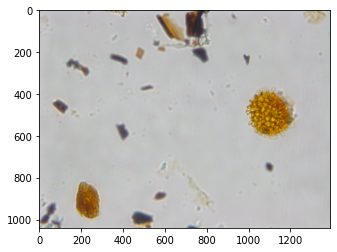

In [ ]:
import matplotlib.image as mpimg

current_image_path=str(current_image_path[0])
for file in sorted(os.listdir(current_image_path)):
    if file.endswith('.bmp'):
      slice = os.path.join(current_image_path, file)

img = mpimg.imread(slice)
plt.imshow(img)

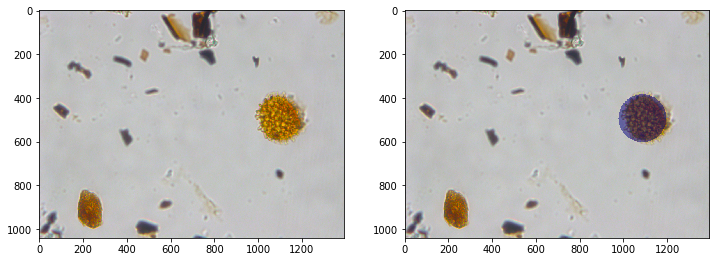

In [ ]:
masked = np.ma.masked_where(detMask == 0, detMask)

plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(img, interpolation='none')
plt.subplot(1,2,2)
plt.imshow(img, interpolation='none')
plt.imshow(masked, 'jet', interpolation='none', alpha=0.5)
plt.show()


Other useful snippets
-----

In [ ]:
# Print the shape of all tensors in the sample

sample = next(iter(dataloaders))
for idx in range(len(sample)):
  print(sample[idx].shape)

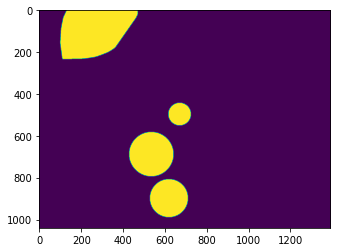

In [ ]:
# Making binary masks from DT

dist_transform = PIL.Image.open('/content/gdrive/MyDrive/UTRECHT/Segmentation/Masks8/PALIV_24-25_slide 1_scan1_19/GT_distTransform.bmp')
dist_transform = np.array(dist_transform)

binary_mask = dist_transform >0.5
im = Image.fromarray((binary_mask*255).astype(np.uint8))
im.save(os.path.join(eval_save_to_folder, 'GT_binaryMask.png'))
plt.imshow(binary_mask)
